### Preprocess 10X v3 data from Kanemaru et al. 2023

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [3]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

In [5]:
%%time
# read in the entire dataset
adata = sc.read_h5ad("Teichman_LV_nuclei.h5ad")

Counter(adata.obs.technology)

CPU times: user 467 ms, sys: 877 ms, total: 1.34 s
Wall time: 1.34 s


Counter({'3prime-v3': 52058, '3prime-v2': 36763, 'Multiome-v1': 33805})

In [6]:
# add study 
adata.obs['study'] = "Kanemaru 2023"

In [7]:
# filter to Multiome
adata = adata[adata.obs.technology == 'Multiome-v1', :].copy()
# store the raw counts
adata.layers["counts"] = adata.X.copy()

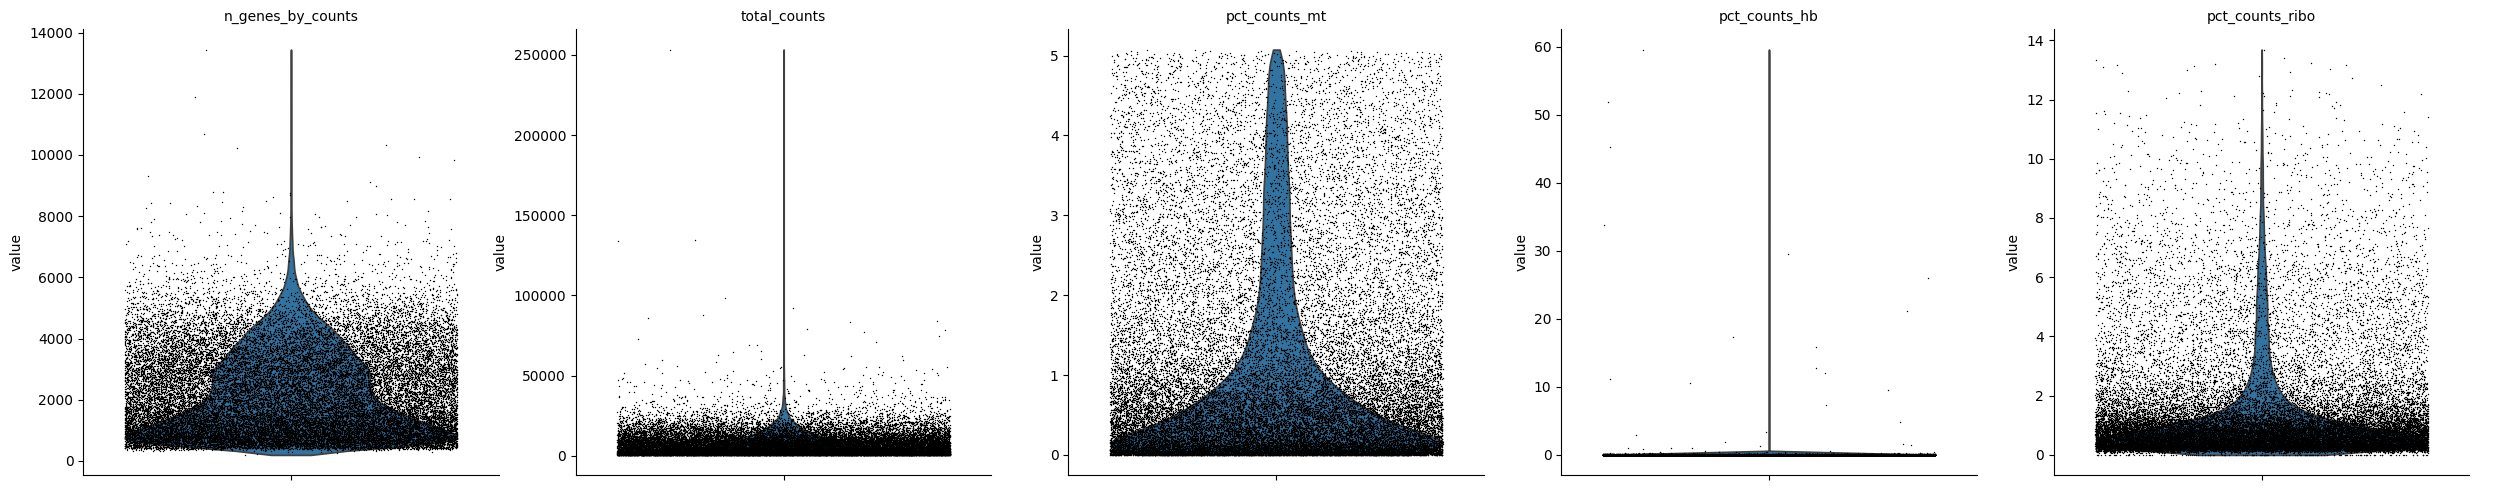

Filtered out 2104 cells
CPU times: user 19.3 s, sys: 20.9 s, total: 40.2 s
Wall time: 5.06 s


In [8]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [9]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 44 likely doublets
CPU times: user 9min 24s, sys: 6min 57s, total: 16min 21s
Wall time: 4min 38s


2024-11-23 13:39:17,107 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-23 13:39:20,039 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-23 13:39:20,160 - harmonypy - INFO - Iteration 1 of 10
2024-11-23 13:39:26,472 - harmonypy - INFO - Iteration 2 of 10
2024-11-23 13:39:33,512 - harmonypy - INFO - Iteration 3 of 10
2024-11-23 13:39:40,553 - harmonypy - INFO - Iteration 4 of 10
2024-11-23 13:39:47,710 - harmonypy - INFO - Iteration 5 of 10
2024-11-23 13:39:54,982 - harmonypy - INFO - Iteration 6 of 10
2024-11-23 13:40:02,285 - harmonypy - INFO - Iteration 7 of 10
2024-11-23 13:40:07,726 - harmonypy - INFO - Converged after 7 iterations


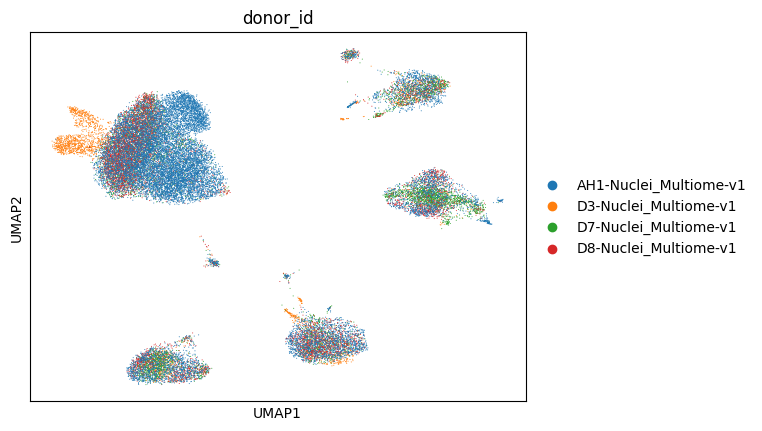

In [10]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

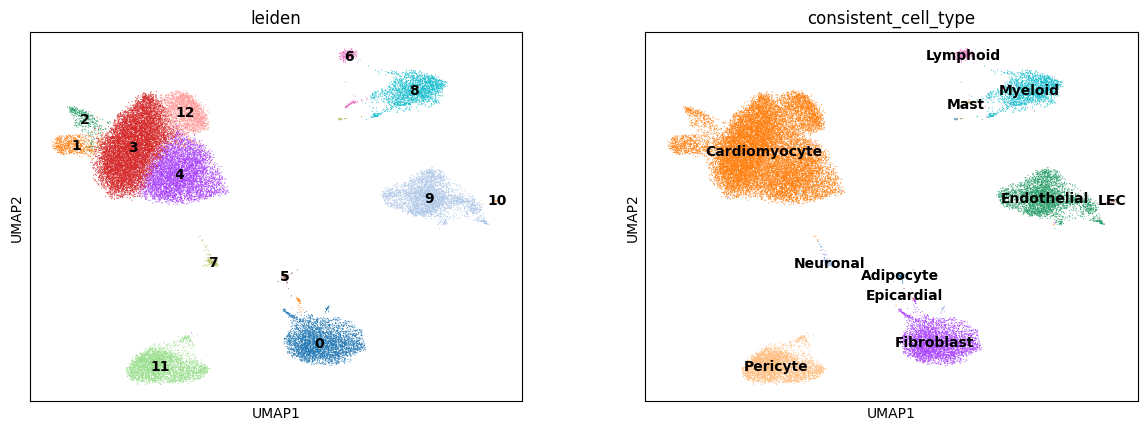

In [11]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

#### Save again

In [ ]:
adata.write("processed_Multiome_adata.h5ad")